In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("MI_DB.csv", index_col=0)
# Replace to NaN and convert to float
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric)

In [3]:
record_count = df.count().to_numpy()
indexes_high_na = np.where( record_count < 1700/2)[0]

name_dropped = df.columns[indexes_high_na].to_numpy() #Keep track of the names of the columns we drop
df = df.drop(df.columns[indexes_high_na], axis = 1)



In [4]:
treshold_na = int(0.3*119) # if more that 50% of missing values, get rid of the row (59)
print("Treshold:",treshold_na)

def calculate_NA(row):
    return row.isna().sum().sum()

df["n_NA"] = df.apply(calculate_NA, axis=1)

np.max(df["n_NA"])

df = df.drop(df[df["n_NA"] > treshold_na].index)
df = df.drop(["n_NA"], axis=1)

df["DEAD"] = df["LET_IS"].apply(lambda x: 1 if x > 0 else 0)

Treshold: 35


In [5]:
numeric_attributes = ["AGE","S_AD_KBRIG","D_AD_KBRIG","S_AD_ORIT","D_AD_ORIT","K_BLOOD","NA_BLOOD",
                      "ALT_BLOOD","AST_BLOOD","KFK_BLOOD","L_BLOOD","ROE"]

numeric_attributes = [x for x in numeric_attributes if x not in name_dropped]

ord_attributes = ["INF_ANAM","STENOK_AN","FK_STENOK","IBS_POST","GB","DLIT_AG","ZSN_A",
                  "ant_im","lat_im","inf_im","post_im","R_AB_1_n","NA_R_1_n","NOT_NA_1_n",
                 "R_AB_2_n","NA_R_2_n","NOT_NA_2_n","R_AB_3_n","NA_R_3_n","NOT_NA_3_n","TIME_B_S"]


ord_attributes = [x for x in ord_attributes if x not in name_dropped]

Y_labels = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS","DEAD"]

att_names = list(df.columns)

bin_attributes = [x for x in att_names if x not in numeric_attributes+ord_attributes+Y_labels]
bin_attributes = [x for x in bin_attributes if x not in name_dropped]

colums_id_Y = [df.columns.get_loc(c) for c in Y_labels if c in df]

In [6]:
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

scaler = preprocessing.StandardScaler()

pipe = make_pipeline(scaler, KNNImputer(n_neighbors=10))

imputer = KNNImputer(n_neighbors=3)
df_i = pipe.fit_transform(df)
df_i = scaler.inverse_transform(df_i)

sf_df = pd.DataFrame(df_i, index=df.index, columns=df.columns)

In [7]:
sf_df[ord_attributes]= sf_df[ord_attributes].apply(round,axis=1)

sf_df[bin_attributes]= sf_df[bin_attributes].apply(round,axis=1)

sf_df_dum = pd.get_dummies(sf_df, columns=ord_attributes)

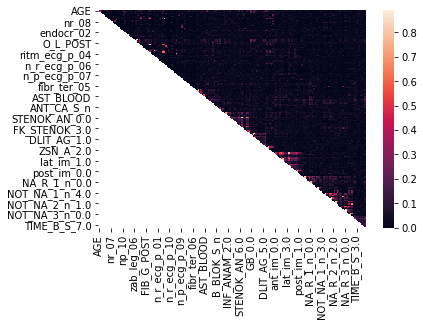

In [9]:
x_cols = bin_attributes+ord_attributes+numeric_attributes
y_cols = Y_labels


x_cols = [x for x in sf_df_dum.columns if x not in Y_labels]

X = sf_df_dum[x_cols]
Y = sf_df_dum[y_cols]

cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

X = X.drop(to_drop, axis=1)
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
sns.heatmap(upper_tri)

scaler.fit(X)
X_sc = scaler.transform(X)
Y_dead = Y["DEAD"].to_numpy()
Y_dead = Y_dead.round().astype(int)

In [10]:
X_sc.shape

(1688, 183)

In [11]:
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchSparsePCA
pca = PCA(n_components=60,random_state=0)
#pca = PCA(n_components=50)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

# Get some curves with LDA

In [13]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

reg_param =np.linspace(0,1,100)
inner_cv = KFold(n_splits=5, shuffle=True)


auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for reg_p in reg_param:

        mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_p)
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()
        

        auc_r.append(auc)
        sen_t.append(tp/(tp+fn))
        spe_t.append(tn/(tn+fp))
        b_a.append(balanced_accuracy_score(y_test_l,y_pred))
    break;



Text(0.5, 0, 'Shrinkage parameter')

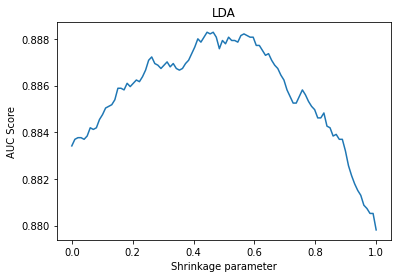

In [14]:

plt.plot(reg_param,auc_r)
plt.title("LDA")
plt.ylabel("AUC Score")
plt.xlabel("Shrinkage parameter")

Text(0.5, 0, 'Shrinkage parameter')

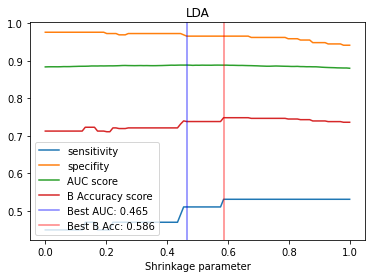

In [15]:

plt.plot(reg_param,sen_t,label="sensitivity")
plt.plot(reg_param,spe_t,label="specifity")
plt.plot(reg_param,auc_r,label="AUC score")
plt.plot(reg_param,b_a,label="B Accuracy score")
plt.axvline(reg_param[np.argmax(auc_r)], 0, 1, label='Best AUC: {:.3f}'.format(reg_param[np.argmax(auc_r)]), color="b", alpha=0.5)
plt.axvline(reg_param[np.argmax(b_a)], 0, 1, label='Best B Acc: {:.3f}'.format(reg_param[np.argmax(b_a)]), color="r", alpha=0.5)
plt.legend()
plt.title("LDA")
plt.xlabel("Shrinkage parameter")

In [18]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

reg_param =np.linspace(0,1,100)
inner_cv = KFold(n_splits=5, shuffle=True)

sp =np.linspace(0.01,0.99,100)
priors = [[item, 1-item] for item in sp]

auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    

    for prior in priors:
        mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=0.899, priors=prior)
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


        auc_r.append(auc)
        sen_t.append(tp/(tp+fn))
        spe_t.append(tn/(tn+fp))
        b_a.append(balanced_accuracy_score(y_test_l,y_pred))

    break;


Text(0.5, 0, 'Priors')

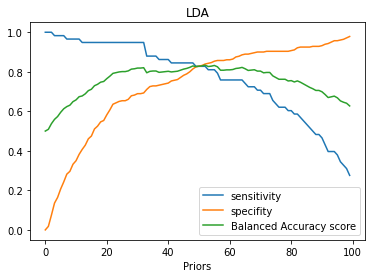

In [19]:

plt.plot(sen_t,label="sensitivity")
plt.plot(spe_t,label="specifity")
plt.plot(b_a,label="Balanced Accuracy score")

plt.legend()
plt.title("LDA")
plt.xlabel("Priors")

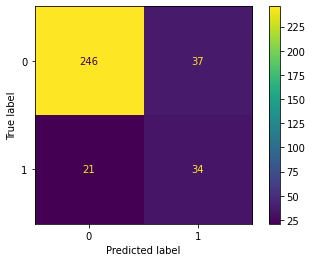

In [21]:
for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=0.899, priors=priors[50])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# Grid search of LDA with shrinkage parameter and priors

In [176]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score


reg_param =np.linspace(0,1,60)
inner_cv = KFold(n_splits=5, shuffle=True)

sp =np.linspace(0.01,0.99,10)
priors = [[item, 1-item] for item in sp]

pca_auc_r = []
pca_sen_t = []
pca_spe_t = []
pca_b_a =[]
    
for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    print(idx)
    runauc_r = []
    runsen_t = []
    runspe_t = []
    runb_a =[]

    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for idx,prior in enumerate(priors):
        
        C_auc = []
        C_sen = []
        C_spe = []
        C_b_a = []
        for reg_p in reg_param:
            mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_p, priors=prior)
            mdl.fit(x_train_l, y_train_l)
            probs = mdl.predict_proba(x_test_l)
            probs = probs[:, 1]
            y_pred = mdl.predict(x_test_l)
            auc = roc_auc_score(y_test_l, probs)
  
            tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


            C_auc.append(auc)
            C_sen.append(tp/(tp+fn))
            C_spe.append(tn/(tn+fp))
            C_b_a.append(balanced_accuracy_score(y_test_l,y_pred))
        
        runauc_r.append(C_auc)
        runsen_t.append(C_sen)
        runspe_t.append(C_spe)
        runb_a.append(C_b_a)
        
    pca_auc_r.append(runauc_r)
    pca_sen_t.append(runsen_t)
    pca_spe_t.append(runspe_t)
    pca_b_a.append(runb_a)

pca_auc_r = np.mean(pca_auc_r, axis=0)
pca_sen_t = np.mean(pca_sen_t, axis=0)
pca_spe_t = np.mean(pca_spe_t, axis=0)
pca_b_a = np.mean(pca_b_a, axis=0)

0
1
2
3
4


([<matplotlib.axis.YTick at 0x13c633dc0>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 10, 'A:1, D:0')])

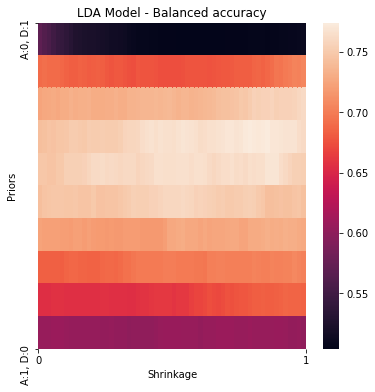

In [136]:
plt.rcParams["figure.figsize"] = (6,6)
sns.heatmap(pca_b_a)

plt.title("LDA Model - Balanced accuracy")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,10],["A:0, D:1","A:1, D:0"])

([<matplotlib.axis.YTick at 0x13ad77700>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 60, 'A:1, D:0')])

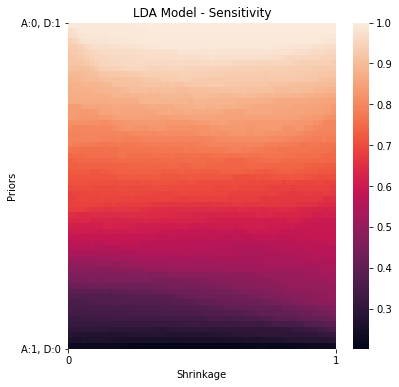

In [105]:
sns.heatmap(pca_sen_t)
plt.title("LDA Model - Sensitivity")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,10],["A:0, D:1","A:1, D:0"])

([<matplotlib.axis.YTick at 0x13ae6d160>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 60, 'A:1, D:0')])

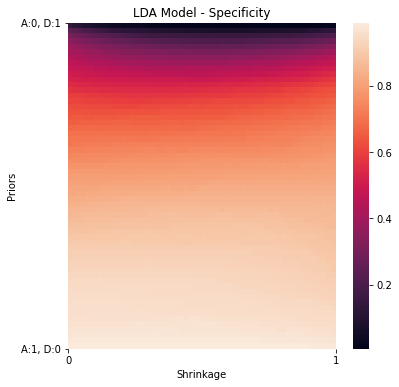

In [106]:
sns.heatmap(pca_spe_t)
plt.title("LDA Model - Specificity")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,60],["A:0, D:1","A:1, D:0"])

([<matplotlib.axis.YTick at 0x13af583d0>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 60, 'A:1, D:0')])

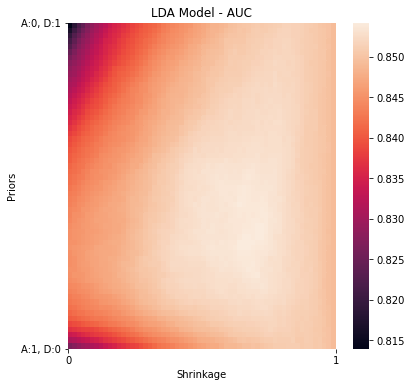

In [107]:
sns.heatmap(pca_auc_r)



([<matplotlib.axis.YTick at 0x13cc6eac0>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 10, 'A:1, D:0')])

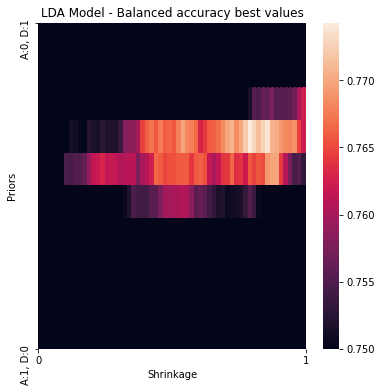

In [146]:
import numpy as np
b = np.where(pca_b_a<0.75,0.75,pca_b_a)
sns.heatmap(b)
plt.title("LDA Model - Balanced accuracy best values")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,10],["A:0, D:1","A:1, D:0"])

([<matplotlib.axis.YTick at 0x13ce08190>,
 [Text(0, 0, 'A:0, D:1'), Text(0, 10, 'A:1, D:0')])

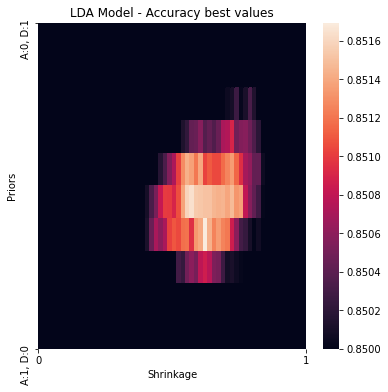

In [147]:
import numpy as np
b = np.where(pca_auc_r<0.85,0.85,pca_auc_r)
sns.heatmap(b)
plt.title("LDA Model - Accuracy best values")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,10],["A:0, D:1","A:1, D:0"])

# CM for max sensitivity

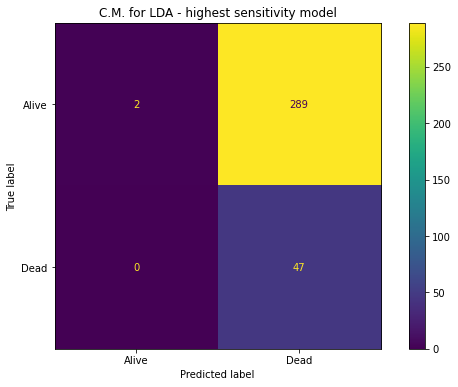

In [91]:
args = np.argwhere(sen_t==np.max(sen_t))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)
    plt.title("C.M. for LDA - highest sensitivity model")
    plt.xticks([0,1],["Alive","Dead"])
    plt.yticks([0,1],["Alive","Dead"])

    break;

# Max specificity

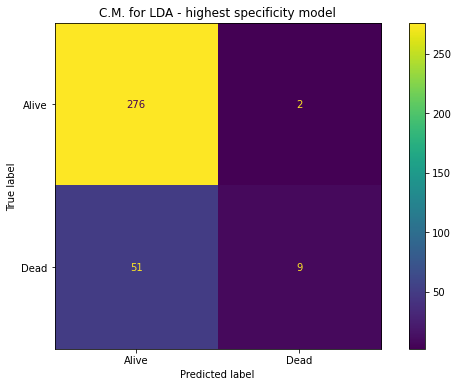

In [92]:
args = np.argwhere(spe_t==np.max(spe_t))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  
    plt.title("C.M. for LDA - highest specificity model")
    plt.xticks([0,1],["Alive","Dead"])
    plt.yticks([0,1],["Alive","Dead"])

    break;

# Max Balanced accuracy

In [179]:
args = np.argwhere(pca_b_a==np.max(pca_b_a))
plt.rcParams.update({'font.size': 16})

mdl_1 = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
args = np.argwhere(pca_auc_r==np.max(pca_auc_r))
mdl_2 =  LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])

tn_roc = []
fp_roc = []
fn_roc = []
tp_roc = []

tn_acc = []
fp_acc = []
fn_acc = []
tp_acc = []

for a in range(5):
    
    for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
        x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
        y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]

        mdl_1.fit(x_train_l, y_train_l)
        y_pred_1 = mdl_1.predict(x_test_l)

        mdl_2.fit(x_train_l, y_train_l)
        y_pred_2 = mdl_2.predict(x_test_l)

        tn1, fp1, fn1, tp1 = confusion_matrix(y_test_l,y_pred_1).ravel()
        tn2, fp2, fn2, tp2 = confusion_matrix(y_test_l,y_pred_2).ravel()
        
        tn_acc.append(tn1)
        tn_roc.append(tn2)
        
        fp_acc.append(fp1)
        fp_roc.append(fp2)
        
        fn_acc.append(fn1)
        fn_roc.append(fn2)
        
        tp_acc.append(tp1)
        tp_roc.append(tp2)
        
        break;

Text(1.3, 1.7, 'σ= 6.8')

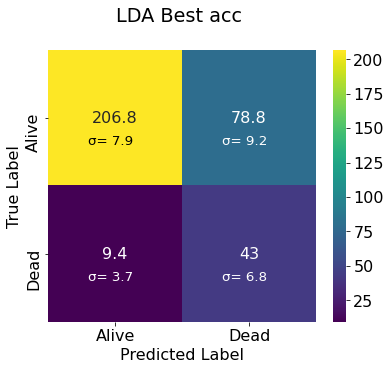

In [185]:
result_acc = [[np.mean(tn_acc),np.mean(fp_acc)],[np.mean(fn_acc),np.mean(tp_acc)]]
result_acc_std = [[np.std(tn_acc),np.std(fp_acc)],[np.std(fn_acc),np.std(tp_acc)]]
plt.rcParams["figure.figsize"] = (6,5)

sns.heatmap(result_acc, annot=True, cmap="viridis",fmt='g')
plt.xticks([0.5,1.5], ["Alive","Dead"])
plt.yticks([0.5,1.5], ["Alive","Dead"])
plt.title("LDA Best acc \n")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.text(0.3,0.7,"σ= {:.1f}".format(np.std(tn_acc)),fontsize="small")
plt.text(0.3,1.7,"σ= {:.1f}".format(np.std(fn_acc)),color="white",fontsize="small")
plt.text(1.3,0.7,"σ= {:.1f}".format(np.std(fp_acc)),color="white",fontsize="small")
plt.text(1.3,1.7,"σ= {:.1f}".format(np.std(tp_acc)),color="white",fontsize="small")

Text(1.3, 1.7, 'σ= 3.3')

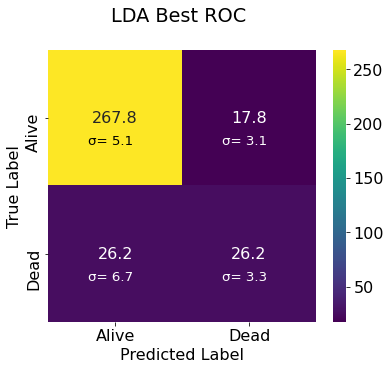

In [184]:
result_roc = [[np.mean(tn_roc),np.mean(fp_roc)],[np.mean(fn_roc),np.mean(tp_roc)]]
plt.rcParams["figure.figsize"] = (6,5)

sns.heatmap(result_roc, annot=True, cmap="viridis",fmt='g')
plt.xticks([0.5,1.5], ["Alive","Dead"])
plt.yticks([0.5,1.5], ["Alive","Dead"])
plt.title("LDA Best ROC \n")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.text(0.3,0.7,"σ= {:.1f}".format(np.std(tn_roc)),fontsize="small")
plt.text(0.3,1.7,"σ= {:.1f}".format(np.std(fn_roc)),color="white",fontsize="small")
plt.text(1.3,0.7,"σ= {:.1f}".format(np.std(fp_roc)),color="white",fontsize="small")
plt.text(1.3,1.7,"σ= {:.1f}".format(np.std(tp_roc)),color="white",fontsize="small")

Text(28.0, 0.5, 'True Label')

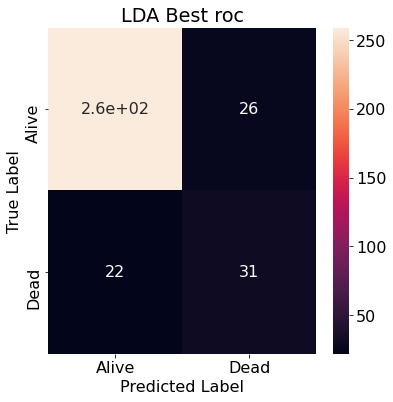

In [172]:
result_roc = [[np.mean(tn_roc),np.mean(fp_roc)],[np.mean(fn_roc),np.mean(tp_roc)]]
result_roc_std = [[np.std(tn_roc),np.std(fp_roc)],[np.std(fn_roc),np.std(tp_roc)]]

sns.heatmap(result_roc, annot=True)
plt.xticks([0.5,1.5], ["Alive","Dead"])
plt.yticks([0.5,1.5], ["Alive","Dead"])
plt.title("LDA Best roc")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Text(28.0, 0.5, 'True Label')

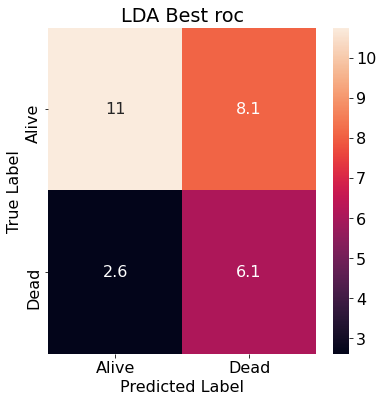

In [173]:
sns.heatmap(result_roc_std, annot=True)
plt.xticks([0.5,1.5], ["Alive","Dead"])
plt.yticks([0.5,1.5], ["Alive","Dead"])
plt.title("LDA Best roc")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

([<matplotlib.axis.YTick at 0x13d65bcd0>,
 [Text(0, 0, 'Alive'), Text(0, 1, 'Dead')])

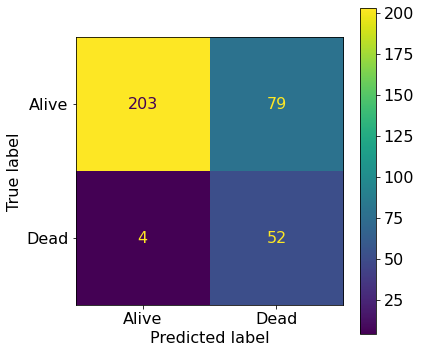

In [164]:
mdl_1.fit(x_train_l, y_train_l)
plot_confusion_matrix(mdl, x_test_l, y_test_l)  

plt.xticks([0,1],["Alive","Dead"])
plt.yticks([0,1],["Alive","Dead"])

([<matplotlib.axis.YTick at 0x13d6e9940>,
 [Text(0, 0, 'Alive'), Text(0, 1, 'Dead')])

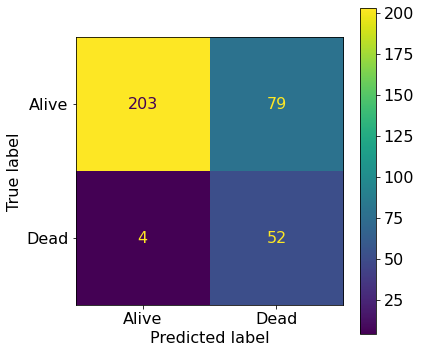

In [165]:
mdl_2.fit(x_train_l, y_train_l)
plot_confusion_matrix(mdl, x_test_l, y_test_l)  

plt.xticks([0,1],["Alive","Dead"])
plt.yticks([0,1],["Alive","Dead"])

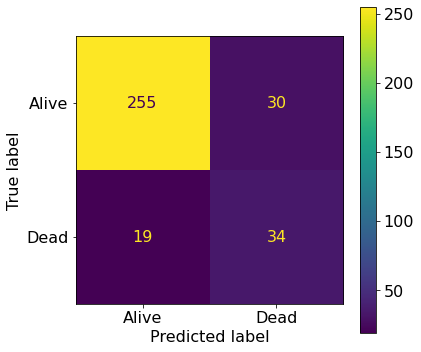

In [154]:
args = np.argwhere(pca_auc_r==np.max(pca_auc_r))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  
    plt.xticks([0,1],["Alive","Dead"])
    plt.yticks([0,1],["Alive","Dead"])

    break;

In [81]:
shrinkage=reg_param[args[0][1]]
priors=priors[args[0][0]]

In [83]:
shrinkage

0.8983050847457628

In [84]:
priors

[0.5249152542372881, 0.47508474576271187]

### Note

We decided as student to choose balanced accuracy as our best metric, but it would be best to see with a medical specialist what is prefered as a sensitivity / specificity balance

# No PCA

In [50]:
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score



reg_param =np.linspace(0,1,60)
inner_cv = KFold(n_splits=5, shuffle=True)

sp =np.linspace(0.01,0.99,60)
priors = [[item, 1-item] for item in sp]

auc_r = []
sen_t = []
spe_t = []
b_a =[]
    
for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    print(idx)
    runauc_r = []
    runsen_t = []
    runspe_t = []
    runb_a =[]

    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for idx,prior in enumerate(priors):
        
        C_auc = []
        C_sen = []
        C_spe = []
        C_b_a = []
        for reg_p in reg_param:
            mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_p, priors=prior)
            mdl.fit(x_train_l, y_train_l)
            probs = mdl.predict_proba(x_test_l)
            probs = probs[:, 1]
            auc = roc_auc_score(y_test_l, probs)
            y_pred = mdl.predict(x_test_l)
            tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


            C_auc.append(auc)
            C_sen.append(tp/(tp+fn))
            C_spe.append(tn/(tn+fp))
            C_b_a.append(balanced_accuracy_score(y_test_l,y_pred))
        
        runauc_r.append(C_auc)
        runsen_t.append(C_sen)
        runspe_t.append(C_spe)
        runb_a.append(C_b_a)
        
    auc_r.append(runauc_r)
    sen_t.append(runsen_t)
    spe_t.append(runspe_t)
    b_a.append(runb_a)

auc_r = np.mean(auc_r, axis=0)
sen_t = np.mean(sen_t, axis=0)
spe_t = np.mean(spe_t, axis=0)
b_a = np.mean(b_a, axis=0)

0
1
2
3
4


([<matplotlib.axis.YTick at 0x139d65a00>,
 [Text(0, 0, '0, 1'), Text(0, 60, '1, 0')])

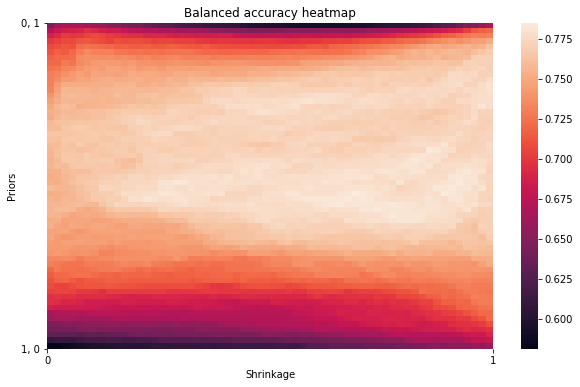

In [51]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(b_a)

plt.title("Balanced accuracy heatmap")
plt.xlabel("Shrinkage")
plt.ylabel("Priors")
plt.xticks([0,60],["0","1"])
plt.yticks([0,60],["0, 1","1, 0"])

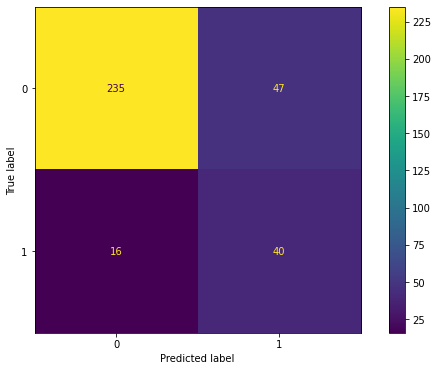

In [67]:
args = np.argwhere(b_a==np.max(b_a))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=reg_param[args[0][1]], priors=priors[args[0][0]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

In [68]:
np.max(b_a)

0.7849847323964032